# Backtest engine

In [1]:
from typing import List, Tuple, Union

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

import quantstats as qs

from pathlib import Path
from tqdm import tqdm

In [2]:
data_path = Path('.').resolve() / 'data'
data_path

WindowsPath('E:/VSCodeProjects/hanaquantchallenge/data')

In [39]:
df = pd.read_pickle(data_path / 'data_quanttrading.pickle')

## Simple alpha example

1. 3번 연속 양봉/음봉이 나오고 
2. 캔들의 크기가 점차 줄어들면서
3. `vwap` 이 2번 연속 떨어질 때 

추세의 반대 방향으로 1주 매매 (reversion)

In [7]:
df.columns

Index(['open', 'high', 'low', 'close', 'vwap', 'volume', 'amount', 'ticks',
       'bid', 'bid_size', 'ask', 'ask_size', 'KST', 'tr_date', 'signal', 'mid',
       'microprice', 'bidask_size_ratio', 'LD_bidask_spread'],
      dtype='object')

In [40]:
from itertools import groupby

def all_equal(iterable):
    g = groupby(iterable)
    return next(g, True) and not next(g, False)

## https://stackoverflow.com/questions/3844801/check-if-all-elements-in-a-list-are-identical

In [90]:
def simple_candle_reversion(df, n=3, use_price='vwap'):
    data_used = ['open', 'high', 'low', 'close', 'vwap']
    dm = df[data_used].copy()

    dm['is_candle_positive'] = np.where(dm['close'] >= dm['open'], 2, -3)
    dm['candle_size'] = dm['high'] - dm['low']
    dm['is_size_decreasing'] = np.where(dm['candle_size'] < dm['candle_size'].shift(1), 5, -7)
    dm['is_vwap_increasing'] = np.where(dm['vwap'] >= dm['vwap'].shift(1), 11, -13)
    

    def is_consecutive(vector):
        if all_equal(vector):
            return vector[0]
        else:
            return 0
    
    dm['case_value'] = dm['is_candle_positive'].rolling(n).apply(is_consecutive) * \
        dm['is_size_decreasing'].rolling(n).apply(is_consecutive) * \
            dm['is_vwap_increasing'].rolling(n).apply(is_consecutive)
    
    dm['alpha'] = np.select(
        condlist=[dm['case_value'] == 2*5*11 , dm['case_value'] == -3*5*-13],
        choicelist=[-1, 1],
        default=0
    )
    
    return dm['alpha'].shift().values
    # return dm

In [91]:
df['position'] = simple_candle_reversion(df)
df.loc[df.index[0], 'position'] = 0

In [92]:
df['position'] = df['position'] * 10

In [93]:
df['signal_unlimited'] = df['position'].diff()
df.loc[df.index[0], 'signal_unlimited'] = 0

In [94]:
pd.DataFrame(
    [
        {'a': 1, 'b': 2},
        {'a': 5, 'b': 4},
        {'a': 8, 'b': 1},
    ]
).diff()

,a,b
0,NaN,NaN
1,4.0,2.0
2,3.0,-3.0


In [95]:
def realize_cashflow_after_trade(
    signal:int, 
    bid_price, 
    bid_size, 
    ask_price, 
    ask_size) -> float:
    """Trade result of one day shifted signal

    Args:
        signal (int): yesterday's buy/sell amount (difference of yesterday & today's position)
        bid_price (float): price when you sell
        bid_size (int): maximum sellable amount
        ask_price (float): price when you buy
        ask_size (int): maximum buyable amount

    Returns:
        int: amount of realized position change from this trade
        float: amount of cash change from this trade
    """    
    if signal == 0:

        return 0, 0.0
    
    elif signal > 0: # 매수시 ask_price로 체결
        traded = min(signal, ask_size)

        return traded, -traded * ask_price
    
    elif signal < 0: # 매도시 bid_price로 체결    
        traded = -min(abs(signal), ask_size)

        return traded, -traded * bid_price


In [96]:
df['cash_chg'] = df.apply(
    lambda row: realize_cashflow_after_trade(
        row['signal_unlimited'], 
        row['bid'],
        row['bid_size'],
        row['ask'],
        row['ask_size'],
        )[1],
    axis=1
    )

In [97]:
INITIAL_CASH = 2e+6

df.loc[df.index[0], 'cash_chg'] = INITIAL_CASH # 최초의 cash amount

In [98]:
df['cash_chg'].sum()

1919105.75

In [99]:
df['position'].iloc[-1] * df['mid'].iloc[-1]

0.0

In [100]:
df['current_actual_position'] = df['signal_unlimited'].cumsum() # TODO: Wrong calculation. signal limited로 해야한다. 

In [101]:
df['current_cash'] = df['cash_chg'].cumsum()

In [102]:
df['current_value'] = df['current_actual_position'] * df['mid'] + df['current_cash']

In [103]:
df['port_return'] = df['current_value'].pct_change()

## Performance analytics using `QuantStats`

`quantstats` 에서 돌리려면 10분 단위로 되어있는 datetime index를 일환산 해줘야 한다. 

In [122]:
daily_port_return = df['port_return'].resample('D').sum()
# daily_port_return.index = daily_port_return.index.tz_localize(None)
# daily_port_return.index = daily_port_return.index.tz_convert(None)

In [115]:
# daily_port_return.index = daily_port_return.index.tz_localize('America/New_York')

In [119]:
daily_port_return.index.dtype

dtype('<M8[ns]')

In [125]:
qs_stats = [f for f in dir(qs.stats) if f[0] != '_']
qs_plots = [f for f in dir(qs.plots) if f[0] != '_']

                           Strategy
-------------------------  ----------
Start Period               2020-01-02
End Period                 2022-09-30
Risk-Free Rate             0.0%
Time in Market             32.0%

Cumulative Return          -3.42%
CAGR﹪                     -1.26%

Sharpe                     -0.07
Prob. Sharpe Ratio         44.12%
Smart Sharpe               -0.07
Sortino                    -0.1
Smart Sortino              -0.1
Sortino/√2                 -0.07
Smart Sortino/√2           -0.07
Omega                      0.97

Max Drawdown               -15.76%
Longest DD Days            295
Volatility (ann.)          7.74%
Calmar                     -0.08
Skew                       -0.08
Kurtosis                   9.72

Expected Daily %           -0.0%
Expected Monthly %         -0.11%
Expected Yearly %          -1.15%
Kelly Criterion            -1.3%
Risk of Ruin               0.0%
Daily Value-at-Risk        -0.8%
Expected Shortfall (cVaR)  -0.8%

Max Consecutive Wins  

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2022-03-22,2022-07-01,2022-09-30,192,-15.758725,-15.420962
2,2021-05-31,2021-09-21,2022-03-21,294,-8.507663,-8.504908
3,2020-01-06,2020-09-16,2020-10-27,295,-5.379193,-4.917285
4,2021-02-22,2021-03-05,2021-03-22,28,-2.524275,-1.266155
5,2020-10-30,2020-12-15,2020-12-23,54,-1.926140,-1.926140


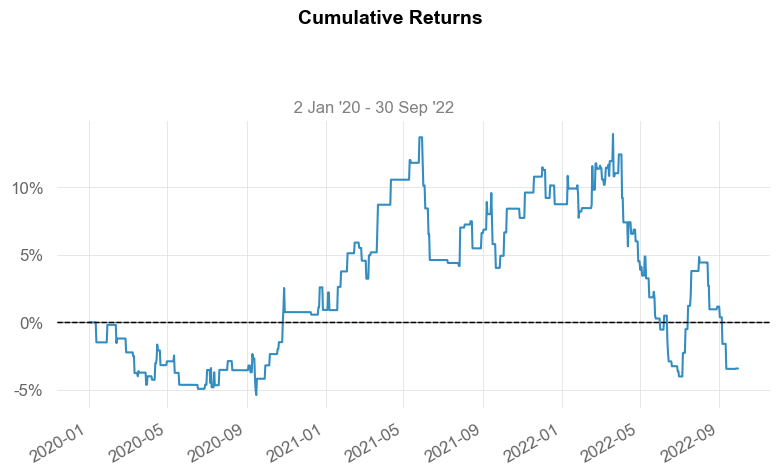

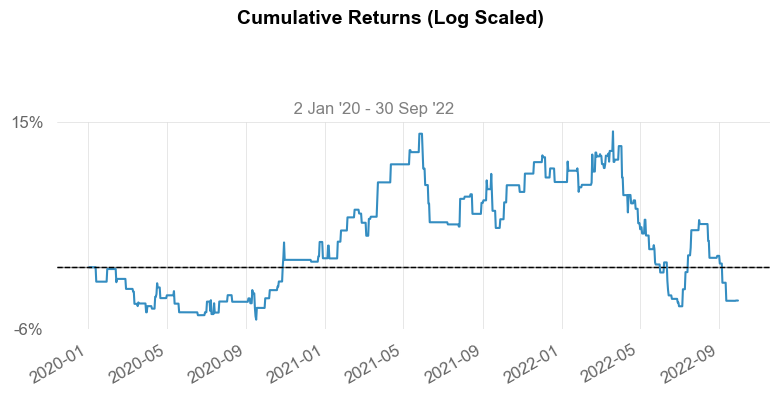

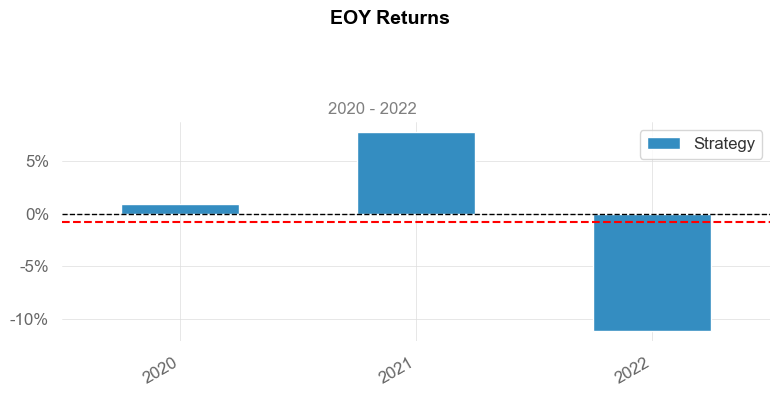

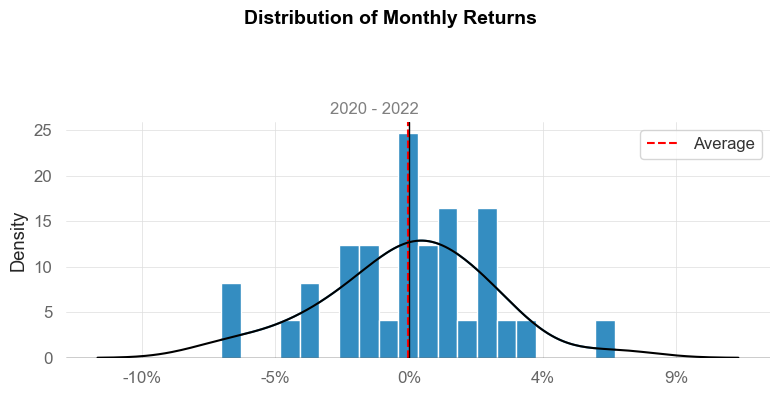

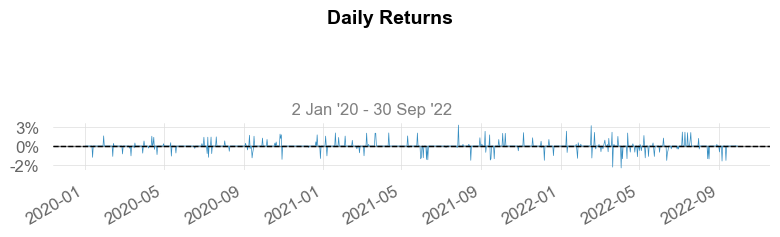

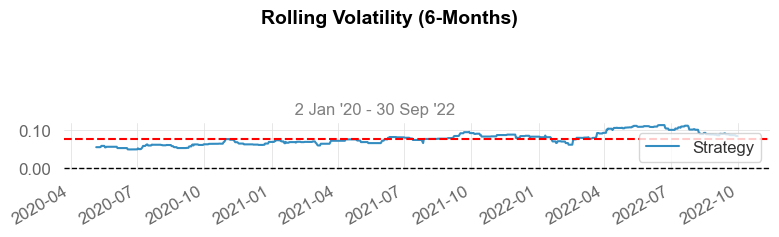

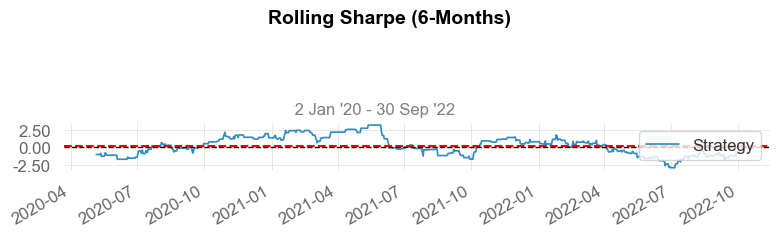

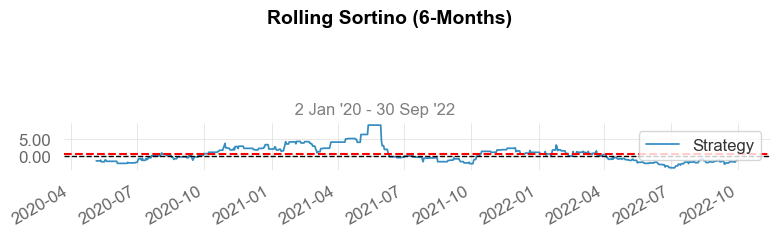

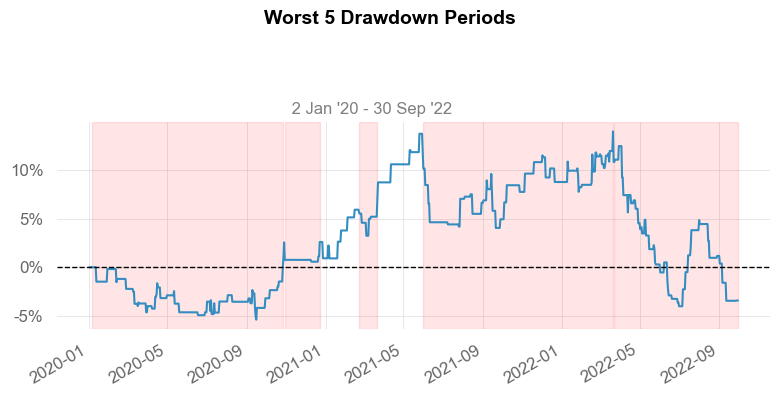

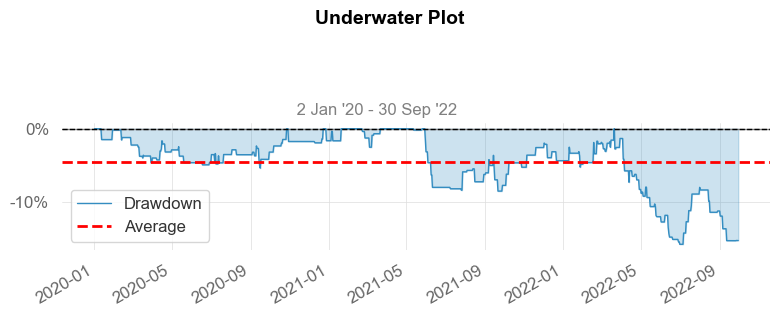

e:\VSCodeProjects\hanaquantchallenge\.venv\lib\site-packages\quantstats\stats.py:968: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  returns = returns.pivot('Year', 'Month', 'Returns').fillna(0)


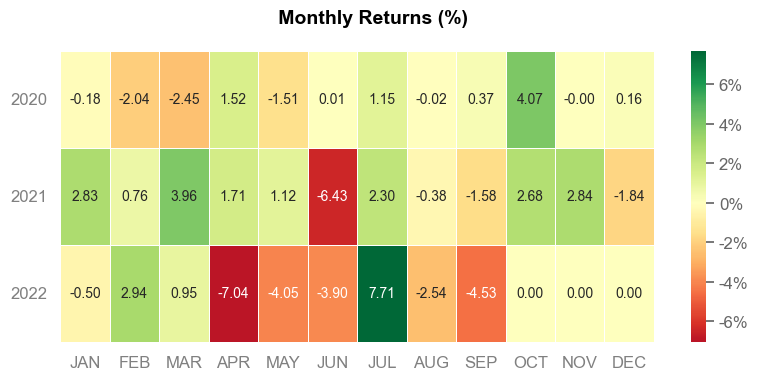

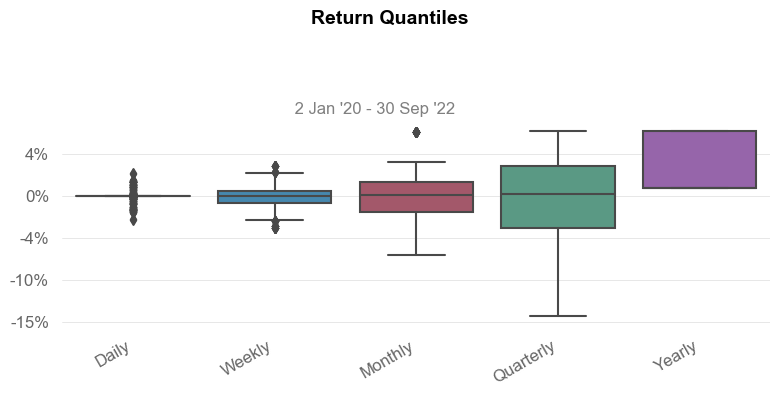

In [128]:
qs.reports.full(daily_port_return)